In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error, explained_variance_score

Downloading Data

In [3]:
data = pd.read_csv('cmm_erdos_2022/pharmacy_tx.csv')

In [7]:
data.sample(5)

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay
1123789,2022-02-05,Pharmacy #35,V97.67,branded cupitelol,664344,NaN,STGRDKR1J5RD,False,10.77
7009446,2022-07-14,Pharmacy #35,M42.24,branded suvinicuvir,725700,NaN,DYGBI610ZY,False,16.48
6382807,2022-06-26,Pharmacy #36,V80.87,generic cycloxasonol,757349,MSCXSG,DGLGRYP,False,19.60
9474302,2022-09-13,Pharmacy #11,Q85.91,generic glycontazepelol,664344,DY4B,NaN,False,17.11
2604928,2022-03-18,Pharmacy #20,Q72.66,branded ratin,322463,NaN,0TZ9XYJZJH,False,21.43


Visualizing Missing Data

<AxesSubplot:>

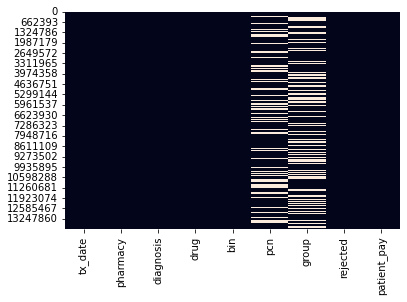

In [35]:
sns.heatmap(data.isnull(), cbar=False)

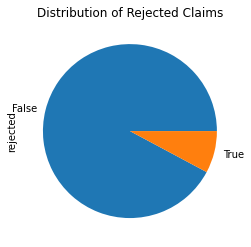

Median patient pay is 13.26 and the mean patient pay is 24.060441242439722


In [42]:
data.rejected.value_counts(normalize=True).plot(kind='pie')
plt.title('Distribution of Rejected Claims')
plt.show()

print(f'Median patient pay is {data.patient_pay.median()} and the mean patient pay is {data.patient_pay.mean()}')

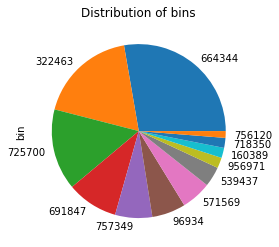

In [41]:
data['bin'].value_counts(normalize=True).plot(kind='pie')
plt.title('Distribution of bins')
plt.show()

Time series model of average patient pay and proportion of rejected claimes.

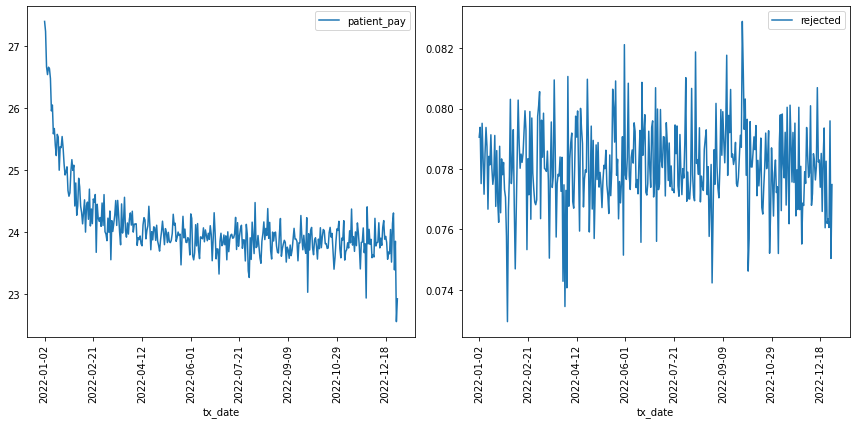

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
data.groupby(['tx_date']).mean().plot(kind='line', y='patient_pay',rot=90,ax=axes[0])
data.groupby(['tx_date']).mean().plot(kind='line', y='rejected',rot=90,ax=axes[1])
fig.tight_layout()
plt.show()

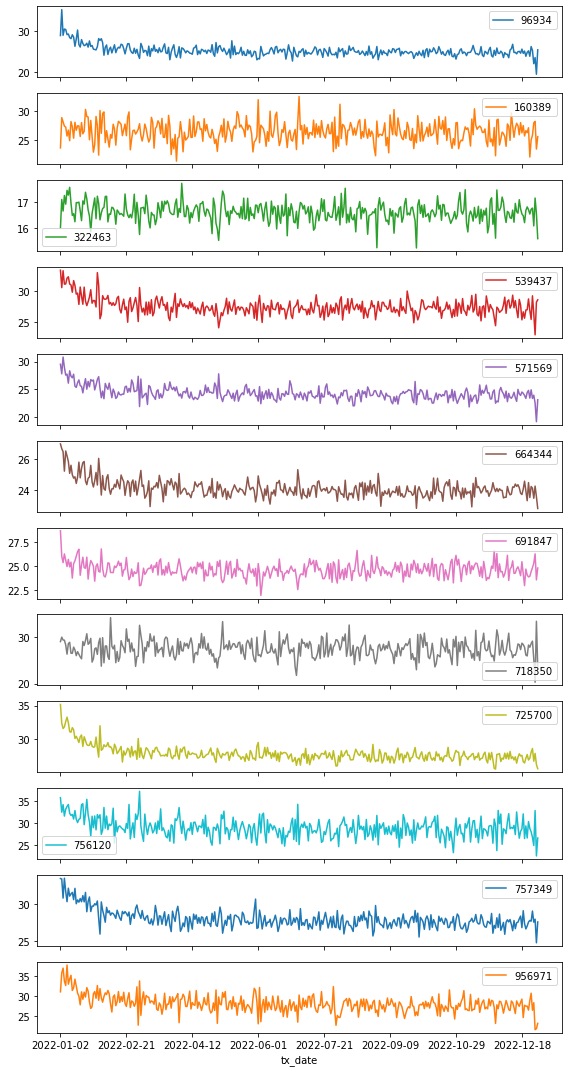

In [47]:
# visualizing individual bins
data.pivot_table(index='tx_date', columns='bin', values='patient_pay'
              ).plot(subplots=True,figsize=(8,15))
plt.tight_layout()

The top-selling drugs are :  ['generic prazinib', 'branded prazinib', 'branded mule', 'branded hidizuzunib', 'generic rulfalol', 'branded rulfalol', 'branded tocilic', 'branded semufolic', 'branded antimab', 'generic pucomalol']

Median of top-selling drugs : 12.22 and the mean : 20.13.

Share of top selling drugs : 28.35.



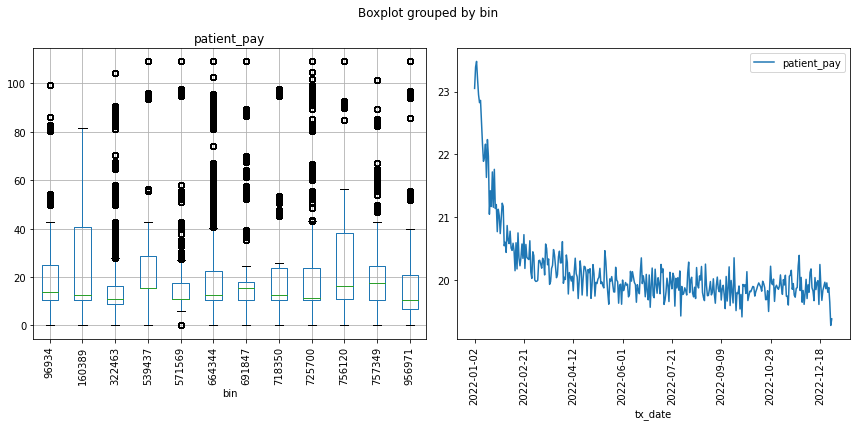

In [65]:
top_drugs = data['drug'].value_counts(normalize=True,sort=True)[:10]
top_drugs = list(top_drugs.to_frame().index)
print('The top-selling drugs are : ',top_drugs,end='\n\n')
top_drugs_df = data.loc[data['drug'].isin(top_drugs)]

print(f'Median of top-selling drugs : {top_drugs_df.patient_pay.median()} and the mean : {top_drugs_df.patient_pay.mean():.2f}.',end='\n\n')

print(f'Share of top selling drugs : {top_drugs_df.patient_pay.sum()/data.patient_pay.sum()*100:.2f}.',end='\n\n')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
top_drugs_df.boxplot(column='patient_pay',by='bin',rot=90,ax=axes[0])
top_drugs_df.groupby(['tx_date']).mean().plot(kind='line', y='patient_pay',rot=90,ax=axes[1])
plt.tight_layout()


The percent of generic drugs is 37.18

The percent of generic drugs rejected is 0.45.

Median patient pay for generic drugs : 10.72 and the mean is 11.46.

Share of generic drugs :0.18.



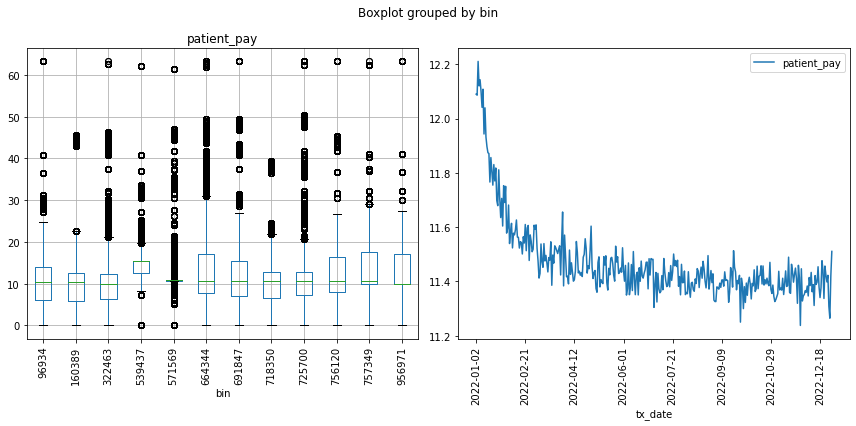

In [66]:
generic_drugs = data.loc[data['drug'].str.startswith('generic')]
print(f'The percent of generic drugs is {(len(generic_drugs)/len(data))*100:.2f}',end='\n\n')
print(f'The percent of generic drugs rejected is {generic_drugs.rejected.value_counts(normalize=True)[1]*100:.2f}.',end='\n\n')
print(f'Median patient pay for generic drugs : {generic_drugs.patient_pay.median()} and the mean is {generic_drugs.patient_pay.mean():.2f}.',end='\n\n')

print(f'Share of generic drugs :{generic_drugs.patient_pay.sum()/data.patient_pay.sum():.2f}.',end='\n\n')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
generic_drugs.boxplot(column='patient_pay',by='bin',rot=90,ax=axes[0])
generic_drugs.groupby(['tx_date']).mean().plot(kind='line', y='patient_pay',rot=90,ax=axes[1])
plt.tight_layout()

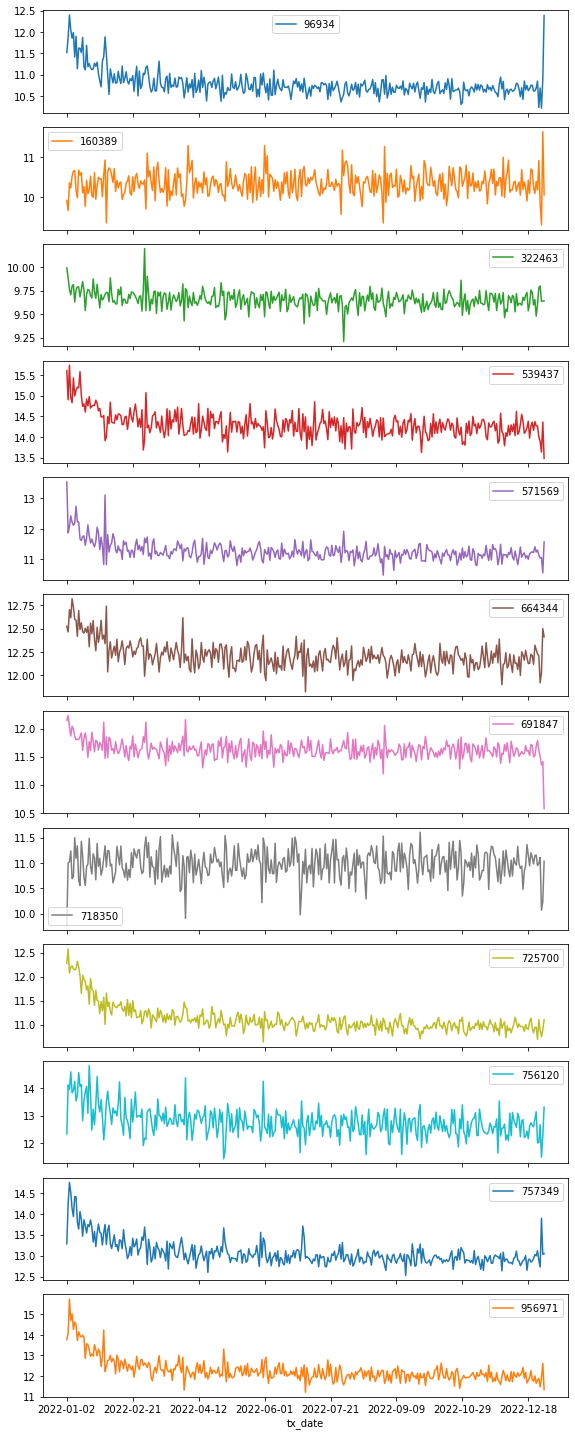

In [67]:
generic_drugs.pivot_table(index='tx_date', columns='bin', values='patient_pay'
            ).plot(subplots=True,figsize=(8,20))
plt.tight_layout()

The percent of branded drugs is 62.82.

The percent of branded drugs rejected is 12.17.

Median patient pay for branded drugs : 16.29 and the mean : 31.52.

Share of branded drugs : 0.82.



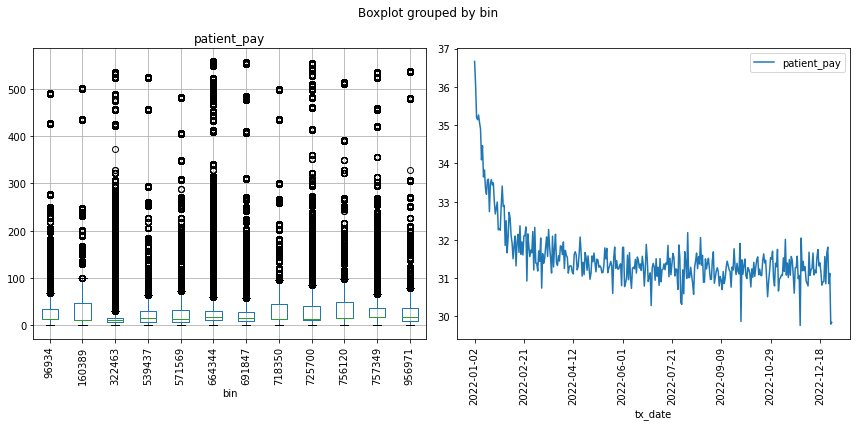

In [69]:
branded_drugs = data.loc[data['drug'].str.startswith('branded')]
print(f'The percent of branded drugs is {(len(branded_drugs)/len(data))*100:.2f}.',end='\n\n')
print(f'The percent of branded drugs rejected is {branded_drugs.rejected.value_counts(normalize=True)[1]*100:.2f}.',end='\n\n')
print(f'Median patient pay for branded drugs : {branded_drugs.patient_pay.median():.2f} and the mean : {branded_drugs.patient_pay.mean():.2f}.',end='\n\n')

print(f'Share of branded drugs : {branded_drugs.patient_pay.sum()/data.patient_pay.sum():.2f}.',end='\n\n')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
branded_drugs.boxplot(column='patient_pay',by='bin',rot=90,ax=axes[0])
branded_drugs.groupby(['tx_date']).mean().plot(kind='line', y='patient_pay',rot=90,ax=axes[1])
plt.tight_layout()

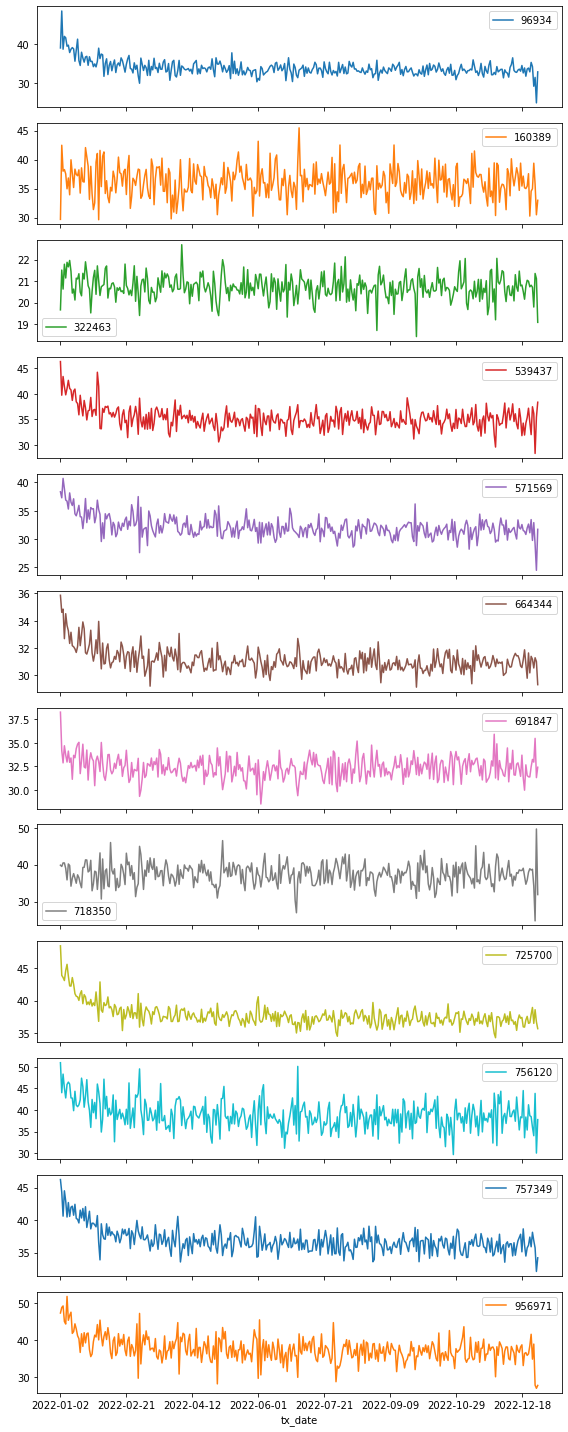

In [70]:
branded_drugs.pivot_table(index='tx_date', columns='bin', values='patient_pay'
              ).plot(subplots=True,figsize=(8,20))
plt.tight_layout()

Feature Selection using groupby

In [79]:
# choosing date, drug, pharmacy and bin as initial features
# grouping them and making mean in each group

data_agg = data.groupby(['tx_date','drug','pharmacy','bin'], as_index=False).patient_pay.mean()
data_agg['predicted'] = data_agg['patient_pay']
del data_agg['patient_pay']

merged = pd.merge(data, data_agg, on=['tx_date','drug','pharmacy','bin'],how='left')
print(f'MSE : {mean_squared_error(merged.patient_pay,merged.predicted):.2f}.')
print(f'MAE : {mean_absolute_error(merged.patient_pay,merged.predicted):.2f}.')
print(f'Explained variance score : {r2_score(merged.patient_pay,merged.predicted):.2f}.') # explained variance score

merged.sample(10)


MSE : 213.12.
MAE : 4.86.
Explained variance score : 0.86.


,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,predicted
5203289,2022-05-26,Pharmacy #27,K87.68,branded kediborin,96934,S76J7V6,NaN,False,45.86,45.860000
1974868,2022-02-26,Pharmacy #52,U27.71,branded tovane,96934,S76J7V6,NaN,False,13.99,13.990000
9043851,2022-09-04,Pharmacy #8,H36.57,branded antimab,664344,CS8580,NaN,False,18.71,20.178333
8093282,2022-08-10,Pharmacy #44,K32.86,branded rulfalol,322463,3O71UTS,NaN,False,12.22,6.936000
12959938,2022-12-06,Pharmacy #7,R33.59,branded fazipilin,664344,W1LW9Y,0OGKQ,True,0.00,43.050000
11627557,2022-11-05,Pharmacy #39,H36.57,branded tocilic,664344,BIZF,QK6BI1N61,False,22.33,23.514000
3889651,2022-04-21,Pharmacy #18,I68.27,branded hidizuzunib,691847,NC7EN,NaN,False,87.06,77.425000
5303434,2022-05-29,Pharmacy #32,K87.68,generic vocopirin,725700,1UQC,NaN,False,10.15,11.110000
5513254,2022-06-06,Pharmacy #0,Q72.66,branded tugesutin,664344,NaN,ZX2QUWR,False,166.59,27.765000
12074940,2022-11-14,Pharmacy #17,I68.27,branded mule,691847,2TIC,XK8RM5E75ZW,False,10.33,15.893333


In [80]:
#including new variable rejected to ['tx_date','drug','pharmacy','bin']

data_agg = data.groupby(['tx_date','drug','pharmacy','bin','rejected'],as_index=False).patient_pay.mean()
data_agg['predicted'] = data_agg['patient_pay']
del data_agg['patient_pay']

merged = pd.merge(data, data_agg, on=['tx_date','drug','pharmacy','bin','rejected'],how='inner')
print(f'MSE : {mean_squared_error(merged.patient_pay,merged.predicted):.2f}.')
print(f'MAE : {mean_absolute_error(merged.patient_pay,merged.predicted):.2f}.')
print(f'Explained variance score : {r2_score(merged.patient_pay,merged.predicted):.2f}.') # explained variance score

merged.sample(10)

MSE : 60.80.
MAE : 2.31.
Explained variance score : 0.96.


,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,predicted
4618013,2022-05-12,Pharmacy #19,K87.68,branded vocopirin,571569,NaN,7LL04USF,False,21.48,21.480000
12265036,2022-11-18,Pharmacy #22,I38.43,branded sorine,322463,NaN,HO8HUGL,False,10.54,10.540000
6662261,2022-07-06,Pharmacy #17,H60.83,generic colifunene,322463,3O71UTS,NaN,False,12.22,12.220000
6567918,2022-07-03,Pharmacy #44,P07.55,generic brede,757349,MSCXSG,DGLGRYP,False,9.83,9.830000
3300420,2022-04-07,Pharmacy #36,I68.27,branded prazinib,756120,7THOQ5,NaN,False,16.42,16.420000
8163997,2022-08-12,Pharmacy #6,M42.24,generic suvinicuvir,664344,YFVIA,AJK5MZ25T9IA,False,17.11,17.110000
12141572,2022-11-16,Pharmacy #18,Q85.91,branded rulfalol,539437,CG3ZWQ,NaN,False,15.47,15.470000
3064781,2022-03-29,Pharmacy #9,W50.87,branded dienulol,757349,RM0HB,SJVO3GXUURRGO,False,10.90,14.230000
3728365,2022-04-18,Pharmacy #34,I68.27,branded mule,322463,NaN,HO8HUGL,False,16.47,29.913333
5190317,2022-05-26,Pharmacy #36,L68.59,branded tocrocin,160389,RB7UU,RS5RB3YA,False,54.96,54.960000


In [83]:
#including feature diagnosis to ['tx_date','drug','pharmacy','bin']

data_agg = data.groupby(['tx_date','drug','pharmacy','bin','diagnosis'],as_index=False).patient_pay.mean()
data_agg['predicted'] = data_agg['patient_pay']
del data_agg['patient_pay']

merged = pd.merge(data, data_agg, on=['tx_date','drug','pharmacy','bin','diagnosis'],how='inner')
print(f'MSE : {mean_squared_error(merged.patient_pay,merged.predicted):.2f}.')
print(f'MAE : {mean_absolute_error(merged.patient_pay,merged.predicted):.2f}.')
print(f'Explained variance score : {r2_score(merged.patient_pay,merged.predicted):.2f}.') # explained variance score

merged.sample(10)

MSE : 141.51.
MAE : 3.28.
Explained variance score : 0.91.


,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,predicted
2173401,2022-03-07,Pharmacy #35,I68.27,branded mule,664344,NaN,STGRDKR1J5RD,False,41.60,35.497500
11559674,2022-11-03,Pharmacy #9,Q85.91,branded pucomalol,571569,KB38N,6BYJBW,False,14.14,14.140000
9584464,2022-09-16,Pharmacy #2,I68.27,generic prazinib,691847,MQWH09H,7Q756WMLLV25X,False,10.72,10.720000
12890286,2022-12-05,Pharmacy #51,I68.27,branded prazinib,664344,NaN,STGRDKR1J5RD,False,11.74,12.606667
5782826,2022-06-12,Pharmacy #4,K32.86,generic pucomalol,571569,KB38N,6BYJBW,False,10.84,10.840000
10230334,2022-10-03,Pharmacy #2,I38.43,generic colifunene,96934,S76J7V6,NaN,False,13.93,13.930000
2733832,2022-03-21,Pharmacy #18,U61.13,generic ratin,664344,NaN,52H8KH0F83K,False,6.11,6.110000
9125827,2022-09-06,Pharmacy #50,G99.93,generic tanoclolol,725700,327CKV,IOEAN1DWVV3Y,False,6.50,6.500000
9746156,2022-09-19,Pharmacy #16,C10.29,branded keglusited,691847,6ZGS97C,NaN,True,0.00,0.000000
2014453,2022-02-28,Pharmacy #18,K87.68,generic vocopirin,571569,FX2Z,OD99VAJGWV,True,0.00,0.000000
